# Graph 2

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from ast import literal_eval
from time import time


In [2]:
def get_data(query: str, conn = None):
    if conn is None:
        conn = psycopg2.connect("dbname='coperimo' user='coperimo' host='localhost'")
    cursor = conn.cursor()
    cursor.execute(query)
    table = cursor.fetchall()
    df = pd.DataFrame(table, columns=[desc[0] for desc in cursor.description])
    return df

In [3]:
covid_ids = get_data(query="SELECT * FROM ml_covid_joined_id LIMIT 20;")
id_list = list(covid_ids.explorys_patient_id.values)
id_list

[513202774,
 637775592,
 515982635,
 637508174,
 637425835,
 654881890,
 513085458,
 505253339,
 513750405,
 495944646,
 497646242,
 637165492,
 510288128,
 656604322,
 513561860,
 471692523,
 655686124,
 512498143,
 644523100,
 480111338]

In [4]:
patient_id = id_list[6]  #{patient_id} 0,2,4,5, 6, 7, 10
patient_id

513085458

In [5]:
# retrieve all drugs prescribed for one patient
query1 = f"""
SELECT * FROM 
(SELECT explorys_patient_id, rx_cui, prescription_date, ingredient_descriptions
FROM v_drug
WHERE explorys_patient_id = {patient_id}
UNION
SELECT explorys_patient_id, rx_cui, prescription_date, ingredient_descriptions
FROM v_drug_new
WHERE explorys_patient_id = {patient_id}) foo ORDER BY prescription_date;
"""
# retrieve all diseases diagnosed for one patient
query2 = f"""
SELECT * FROM 
(SELECT explorys_patient_id, icd_code, icd_version, diagnosis_date
FROM v_diagnosis
WHERE explorys_patient_id = {patient_id}
UNION
SELECT explorys_patient_id, icd_code, icd_version, diagnosis_date
FROM v_diagnosis_new
WHERE explorys_patient_id = {patient_id}) bar ORDER BY diagnosis_date;
"""

#retrieve drugs common in patient data and medi data (literature)  # v_drug_covid table not union
query3 = f"""
SELECT * FROM
(SELECT rx_cui FROM v_drug WHERE explorys_patient_id = {patient_id}
UNION
SELECT rx_cui FROM v_drug_new WHERE explorys_patient_id = {patient_id}) foo
INTERSECT
SELECT rxcui FROM ka_medi_associations;
"""

#retrieve diagnosis common in patient data and medi data (literature)
query4 = f"""
SELECT * FROM
(SELECT icd_code FROM v_diagnosis WHERE explorys_patient_id = {patient_id}
UNION
SELECT icd_code FROM v_diagnosis_new WHERE explorys_patient_id = {patient_id}) foo
INTERSECT
SELECT icd_code FROM ka_medi_associations;
"""

#retrieve diagnosis common in patient data and disgenet data (literature)
query5 = f"""
SELECT * FROM
(SELECT icd_code FROM v_diagnosis WHERE explorys_patient_id = {patient_id}
UNION
SELECT icd_code FROM v_diagnosis_new WHERE explorys_patient_id = {patient_id}) foo
INTERSECT
SELECT icd_code FROM ka_disgenet_mappings;
"""

#retrieve drug-diagnosis associations from medi
query6 = "SELECT * FROM ka_medi_associations;"

#retrieve diagnosis-diagnosis associations from disgenet
query7 = "SELECT * FROM ka_disgenet_associations;"

#retrieve diagnosis-diagnosis associations from disgenet
query8 = "SELECT * FROM ka_disgenet_mappings;"


In [6]:
patient_drugs = get_data(query= query1)
patient_drugs = patient_drugs.dropna()
patient_drugs['new_date'] = patient_drugs['prescription_date'].apply(lambda x: x.date()) #only date

patient_diagnosis = get_data(query=query2)
patient_diagnosis = patient_diagnosis.dropna()
patient_diagnosis['new_date'] = patient_diagnosis['diagnosis_date'].apply(lambda x: x.date()) #only date

In [7]:
lit_drugs = get_data(query=query3)

lit_diagnosis1 = get_data(query=query4)
lit_diagnosis2 = get_data(query=query5)
lit_diagnosis = lit_diagnosis1.append(lit_diagnosis2, ignore_index=True)
lit_diagnosis.drop_duplicates(subset='icd_code', ignore_index=True, inplace=True)

medi_associations = get_data(query=query6)
dnet_associations = get_data(query=query7)
dnet_associations.assocations = dnet_associations.assocations.apply(literal_eval)

dnet_mappings = get_data(query=query8)

# icd associations
icd_relations = get_data("SELECT * FROM ka_icd_associations;")

In [49]:
patient_diagnosis

,explorys_patient_id,icd_code,icd_version,diagnosis_date,new_date
0,513085458,N40.0,ICD10,2011-12-02,2011-12-02
1,513085458,302.70,ICD9,2011-12-02,2011-12-02
2,513085458,600.00,ICD9,2011-12-02,2011-12-02
3,513085458,601.9,ICD9,2011-12-02,2011-12-02
4,513085458,N41.9,ICD10,2011-12-02,2011-12-02
...,...,...,...,...,...
331,513085458,401.9,ICD9,2020-12-30,2020-12-30
332,513085458,079.89,ICD9,2021-01-05,2021-01-05
333,513085458,U07.1,ICD10,2021-01-05,2021-01-05
334,513085458,U07.1,ICD10,2021-01-06,2021-01-06


In [71]:
lidi = patient_diagnosis[(patient_diagnosis['icd_code'].isin(medi_associations.icd_code.unique())) | (patient_diagnosis['icd_code'].isin(icd_relations['disease1'].append(icd_relations['disease2']).unique()))]
lidi

,explorys_patient_id,icd_code,icd_version,diagnosis_date,new_date
0,513085458,N40.0,ICD10,2011-12-02,2011-12-02
1,513085458,302.70,ICD9,2011-12-02,2011-12-02
3,513085458,601.9,ICD9,2011-12-02,2011-12-02
4,513085458,N41.9,ICD10,2011-12-02,2011-12-02
5,513085458,R37,ICD10,2011-12-02,2011-12-02
...,...,...,...,...,...
328,513085458,079.89,ICD9,2020-12-30,2020-12-30
329,513085458,I10,ICD10,2020-12-30,2020-12-30
331,513085458,401.9,ICD9,2020-12-30,2020-12-30
332,513085458,079.89,ICD9,2021-01-05,2021-01-05


In [72]:
len(lidi.icd_code.unique())

73

In [73]:
lit_diagnosis

,icd_code
0,R04.0
1,401.1
2,J34.89
3,599.0
4,302.70
...,...
76,789.03
77,367.0
78,M25.559
79,362.57


In [74]:
for i in lit_diagnosis.icd_code.values:
    if i not in lidi.icd_code.unique():
        print(i)

367.4
R10.31
M54.16
H52.4
366.8
789.03
M25.559
362.57


In [43]:
patient_drugs

,explorys_patient_id,rx_cui,prescription_date,ingredient_descriptions,new_date
0,513085458,849574,2011-12-02 14:26:00,Naproxen,2011-12-02
1,513085458,863669,2011-12-02 14:26:00,tamsulosin,2011-12-02
2,513085458,402019,2011-12-02 14:26:00,tadalafil,2011-12-02
3,513085458,858817,2011-12-02 14:26:00,Enalapril,2011-12-02
4,513085458,309309,2011-12-02 15:36:00,Ciprofloxacin,2011-12-02
...,...,...,...,...,...
148,513085458,9863,2021-01-06 09:43:00,Sodium Chloride,2021-01-06
149,513085458,727373,2021-01-06 09:43:00,Epinephrine,2021-01-06
150,513085458,747260,2021-01-06 09:43:00,Sodium Chloride,2021-01-06
151,513085458,745679,2021-01-06 09:43:00,Albuterol,2021-01-06


In [42]:
liti = patient_drugs[(patient_drugs['rx_cui'].isin(medi_associations.rxcui.unique()))]
#liti = medi_associations[medi_associations['rxcui'].isin(patient_drugs.rx_cui.unique())]
liti

,explorys_patient_id,rx_cui,prescription_date,ingredient_descriptions,new_date
39,513085458,762675,2012-05-28 13:26:00,Methylprednisolone,2012-05-28
41,513085458,5956,2012-05-31 10:10:00,Iohexol,2012-05-31
46,513085458,5956,2012-06-26 13:47:00,Iohexol,2012-06-26
82,513085458,762675,2015-04-20 15:43:00,Methylprednisolone,2015-04-20
108,513085458,1399,2017-04-05 09:08:00,Benzocaine,2017-04-05
109,513085458,1399,2017-04-05 09:09:00,Benzocaine,2017-04-05
142,513085458,762675,2021-01-05 12:08:00,Methylprednisolone,2021-01-05
148,513085458,9863,2021-01-06 09:43:00,Sodium Chloride,2021-01-06


In [18]:
lit_drugs

,rx_cui
0,762675
1,9863
2,5956
3,1399


In [9]:
icd_relations

,disease1,disease2
0,704.1,K59.09
1,C50,N12
2,Q36,Q70.10
3,494,R07.4
4,712.3,E24.9
...,...,...
106658,M04.8,M60.9
106659,I34.0,M21.20
106660,188.9,781.6
106661,564.00,M21.2


In [60]:
len(icd_relations.disease1.unique()), len(icd_relations.disease2.unique()), len(icd_relations['disease1'].append(icd_relations['disease2']).unique())

(3419, 3345, 3645)

In [37]:
only_drugs = medi_associations[medi_associations['rxcui'].isin(lit_drugs.rx_cui.values)]
only_drugs

,rxcui,icd_code
9903,1399,B00
9904,1399,B00.1
9905,1399,B00.9
9906,1399,B02
9907,1399,B02.9
...,...,...
181827,762675,G40.909
181828,762675,G93.89
181829,762675,K63.3
181830,762675,K90.0


In [22]:
only_drugs = medi_associations[(medi_associations['rxcui'].isin(lit_drugs.rx_cui.values)) & (medi_associations['icd_code'].isin(lit_diagnosis.icd_code.values))]
only_drugs

,rxcui,icd_code
9907,1399,B02.9
10005,1399,053.9
10047,1399,401.9
10054,1399,478.19
10082,1399,780.79
10092,1399,786.09
85774,9863,B02.9
85830,9863,I10
85842,9863,J30.9
85846,9863,J34.89


In [24]:
only_diags = icd_relations[(icd_relations['disease1'].isin(lit_diagnosis.icd_code.values)) & (icd_relations['disease2'].isin(lit_diagnosis.icd_code.values))]
only_diags

,disease1,disease2
11940,I10,N39.0
13130,I10,R04.0
14170,724.5,M54.5
14338,J30.9,R04.0
15882,599.0,I10
23877,784.7,J30.9
30766,728.71,M72.2
33144,401.9,I10
36220,K40.90,R53.83
36606,724.2,R53.83


In [8]:
dnet_associations

,disease_id2,disease_id1,assocations
0,C0000737,C0002871,"[(789.0, D64.9), (789.0, 285.9), (789.00, D64...."
1,C0000737,C0002878,"[(789.0, D55-D59.9), (789.0, D55-D59), (789.00..."
2,C0000737,C0002879,"[(789.0, D59), (789.0, 283.9), (789.0, 283), (..."
3,C0000737,C0002994,"[(789.0, T78.3), (789.00, T78.3), (R10.9, T78.3)]"
4,C0000737,C0003123,"[(789.0, R63.0), (789.0, 783.0), (789.00, R63...."
...,...,...,...
59503,C4721453,C1297882,"[(G64, Q92.2), (350-359.99, Q92.2)]"
59504,C4721453,C1395852,"[(G64, Q69.1), (350-359.99, Q69.1)]"
59505,C4721453,C2239176,"[(G64, C22.0), (350-359.99, C22.0)]"
59506,C4721453,C3542501,"[(G64, 357.0), (350-359.99, 357.0)]"


In [9]:
asses = dnet_associations[dnet_associations['disease_id2'] == 'C0020538']
asses

,disease_id2,disease_id1,assocations
19045,C0020538,C0000737,"[(I10-I15.9, 789.0), (I10-I15.9, 789.00), (I10..."
19046,C0020538,C0001231,"[(I10-I15.9, E24.3), (997.91, E24.3), (I10, E2..."
19047,C0020538,C0001925,"[(I10-I15.9, R80.9), (997.91, R80.9), (I10, R8..."
19048,C0020538,C0001948,"[(I10-I15.9, Z72.1), (997.91, Z72.1), (I10, Z7..."
19049,C0020538,C0001973,"[(I10-I15.9, F10.2), (I10-I15.9, 303), (997.91..."
...,...,...,...
19381,C0020538,C3160858,"[(I10-I15.9, I67.83), (997.91, I67.83), (I10, ..."
19382,C0020538,C3241937,"[(I10-I15.9, K75.81), (997.91, K75.81), (I10, ..."
19383,C0020538,C3837958,"[(I10-I15.9, E10), (997.91, E10), (I10, E10), ..."
19384,C0020538,C4048158,"[(I10-I15.9, 780.3), (I10-I15.9, R56.9), (997...."


In [58]:
list(np.array(asses.assocations.to_list).flat)

[<bound method IndexOpsMixin.tolist of 19045    [(I10-I15.9, 789.0), (I10-I15.9, 789.00), (I10...
 19046    [(I10-I15.9, E24.3), (997.91, E24.3), (I10, E2...
 19047    [(I10-I15.9, R80.9), (997.91, R80.9), (I10, R8...
 19048    [(I10-I15.9, Z72.1), (997.91, Z72.1), (I10, Z7...
 19049    [(I10-I15.9, F10.2), (I10-I15.9, 303), (997.91...
                                ...                        
 19381    [(I10-I15.9, I67.83), (997.91, I67.83), (I10, ...
 19382    [(I10-I15.9, K75.81), (997.91, K75.81), (I10, ...
 19383    [(I10-I15.9, E10), (997.91, E10), (I10, E10), ...
 19384    [(I10-I15.9, 780.3), (I10-I15.9, R56.9), (997....
 19385    [(I10-I15.9, 530.3), (I10-I15.9, K22.2), (997....
 Name: assocations, Length: 339, dtype: object>]

In [14]:
counter1 = 0
counter2 = 0
jiji = []
for i in asses.assocations.values:
    counter1 += len(i)
    for j in i:
        counter2 += 1
        jiji.append(j)
        #jiji.append(tuple(sorted(j)))

counter1, counter2

(2624, 2624)

In [15]:
jiji

[('I10-I15.9', '789.0'),
 ('I10-I15.9', '789.00'),
 ('I10-I15.9', 'R10.9'),
 ('997.91', '789.0'),
 ('997.91', '789.00'),
 ('997.91', 'R10.9'),
 ('I10', '789.0'),
 ('I10', '789.00'),
 ('I10', 'R10.9'),
 ('401-405.99', '789.0'),
 ('401-405.99', '789.00'),
 ('401-405.99', 'R10.9'),
 ('I10-I15.9', 'E24.3'),
 ('997.91', 'E24.3'),
 ('I10', 'E24.3'),
 ('401-405.99', 'E24.3'),
 ('I10-I15.9', 'R80.9'),
 ('997.91', 'R80.9'),
 ('I10', 'R80.9'),
 ('401-405.99', 'R80.9'),
 ('I10-I15.9', 'Z72.1'),
 ('997.91', 'Z72.1'),
 ('I10', 'Z72.1'),
 ('401-405.99', 'Z72.1'),
 ('I10-I15.9', 'F10.2'),
 ('I10-I15.9', '303'),
 ('997.91', 'F10.2'),
 ('997.91', '303'),
 ('I10', 'F10.2'),
 ('I10', '303'),
 ('401-405.99', 'F10.2'),
 ('401-405.99', '303'),
 ('I10-I15.9', 'E87.3'),
 ('I10-I15.9', '276.3'),
 ('997.91', 'E87.3'),
 ('997.91', '276.3'),
 ('I10', 'E87.3'),
 ('I10', '276.3'),
 ('401-405.99', 'E87.3'),
 ('401-405.99', '276.3'),
 ('I10-I15.9', 'J67.9'),
 ('I10-I15.9', '495'),
 ('I10-I15.9', '495.9'),
 ('997.91',

In [12]:
jaja = set(jiji)
jaja

{('I10', 'R52.9'),
 ('I10', 'R06.4'),
 ('210-229.99', '997.91'),
 ('997.91', 'K74.60'),
 ('I10-I15.9', 'J43'),
 ('780.57', '997.91'),
 ('I10-I15.9', 'I50.1'),
 ('389.10', 'I10-I15.9'),
 ('E87.3', 'I10-I15.9'),
 ('606.9', 'I10'),
 ('997.91', 'D65'),
 ('C00-C97.9', 'I10-I15.9'),
 ('283.11', 'I10-I15.9'),
 ('210-229.99', 'I10'),
 ('290', 'I10-I15.9'),
 ('401-405.99', '657.0'),
 ('343.3', '997.91'),
 ('780.57', 'I10'),
 ('D47.Z2', 'I10'),
 ('338-338.99', '997.91'),
 ('458.9', 'I10-I15.9'),
 ('997.91', 'J43.9'),
 ('362.0', 'I10'),
 ('642.3', '997.91'),
 ('C76.0', 'I10'),
 ('997.91', 'R73'),
 ('176.9', '401-405.99'),
 ('I10-I15.9', 'R47.81'),
 ('B21.0', 'I10'),
 ('997.91', 'N40-N51.9'),
 ('I10-I15.9', 'Q22.1'),
 ('997.91', 'G03.0'),
 ('401-405.99', '431'),
 ('F41.9', 'I10'),
 ('780.7', '997.91'),
 ('I10-I15.9', 'I80'),
 ('401-405.99', 'C00-D48.9'),
 ('997.91', 'G80.9'),
 ('754.51', 'I10'),
 ('997.91', 'R52'),
 ('153.9', '401-405.99'),
 ('997.91', 'R40.1'),
 ('I10', 'R04.0'),
 ('I10-I15.9', '

In [13]:
len(jiji), len(jaja)

(2624, 2512)

In [9]:
# dnet_mappings

In [10]:
patient_drugs

,explorys_patient_id,rx_cui,prescription_date,ingredient_descriptions,new_date
0,513085458,849574,2011-12-02 14:26:00,Naproxen,2011-12-02
1,513085458,863669,2011-12-02 14:26:00,tamsulosin,2011-12-02
2,513085458,402019,2011-12-02 14:26:00,tadalafil,2011-12-02
3,513085458,858817,2011-12-02 14:26:00,Enalapril,2011-12-02
4,513085458,309309,2011-12-02 15:36:00,Ciprofloxacin,2011-12-02
...,...,...,...,...,...
148,513085458,9863,2021-01-06 09:43:00,Sodium Chloride,2021-01-06
149,513085458,727373,2021-01-06 09:43:00,Epinephrine,2021-01-06
150,513085458,747260,2021-01-06 09:43:00,Sodium Chloride,2021-01-06
151,513085458,745679,2021-01-06 09:43:00,Albuterol,2021-01-06


In [11]:
patient_diagnosis

,explorys_patient_id,icd_code,icd_version,diagnosis_date,new_date
0,513085458,N40.0,ICD10,2011-12-02,2011-12-02
1,513085458,302.70,ICD9,2011-12-02,2011-12-02
2,513085458,600.00,ICD9,2011-12-02,2011-12-02
3,513085458,601.9,ICD9,2011-12-02,2011-12-02
4,513085458,N41.9,ICD10,2011-12-02,2011-12-02
...,...,...,...,...,...
331,513085458,401.9,ICD9,2020-12-30,2020-12-30
332,513085458,079.89,ICD9,2021-01-05,2021-01-05
333,513085458,U07.1,ICD10,2021-01-05,2021-01-05
334,513085458,U07.1,ICD10,2021-01-06,2021-01-06


# Graph Construction

In [12]:
# fig, ax = plt.subplots(figsize=(15,15))

# #G = nx.from_pandas_edgelist(patient_drugs, 'explorys_patient_id', 'prescription_date', create_using=nx.Graph())
# G = nx.Graph()
# for drug in patient_drugs.rx_cui.values:
#     G.add_node(drug, color='orange')

# for diag in patient_diagnosis.icd_code.values:
#     G.add_node(diag, color='green')

# for rxcui in lit_drugs.rx_cui.values:
#     med = medi_associations[medi_associations['rxcui'] == rxcui]
#     for i in med.icd_code.values:
#         if i in G.nodes:
#             G.add_edge(rxcui, i, color='blue')

# for icd_code in lit_diagnosis.icd_code.values:
#     ind = medi_associations[medi_associations['icd_code'] == icd_code]
#     for i in ind.rxcui.values:
#         if i in G.nodes:
#             G.add_edge(icd_code, i, color='yellow')

# attr = list(nx.get_node_attributes(G, 'color').values())
# attr2 = list(nx.get_edge_attributes(G, 'color').values()) #edge_color

# pos= nx.spring_layout(G, k=0.5)
# nx.draw(G, pos=pos,  with_labels=True, node_color=attr, edge_color=attr2)

# Backtracking method 1 - Fast

from drug, diagnosis in the literature_only edges:

  if diagnosis_date is equal to/ between some time span of prescription_date:
    
    change edge color

In [13]:
# found_dd_associations = set()
# for icd1, icd2 in PG.edges:
#     if PG[icd1][icd2]['color'] == 'green':
#         diags_date = patient_diagnosis.loc[(patient_diagnosis['icd_code'] == icd1) | (patient_diagnosis['icd_code'] == icd2),['icd_code', 'new_date']]
#         first_diag = diag_date.iloc[0,0]
#         for index, row in diags_date.iterrows():
#             end_date = row.new_date + timedelta(days=365)  #time span in days between two diagnosis
#             for diag2_visit in diag2_date:
#                 if diag1_visit <= diag2_visit <= end_date:
#                     found_dd_associations.add((icd1, icd2))
#                 if diag2_visit <= diag1_visit <= end_date:
#                     found_dd_associations.add((icd1, icd2))

0.0007464885711669922 Add nodes
0.0360560417175293 Add drug_diags
0.013951778411865234 check dtug-diags
0.0019512176513671875 Add diag-diag
0.035323381423950195 check diag-diag
0.18663763999938965 higlighting


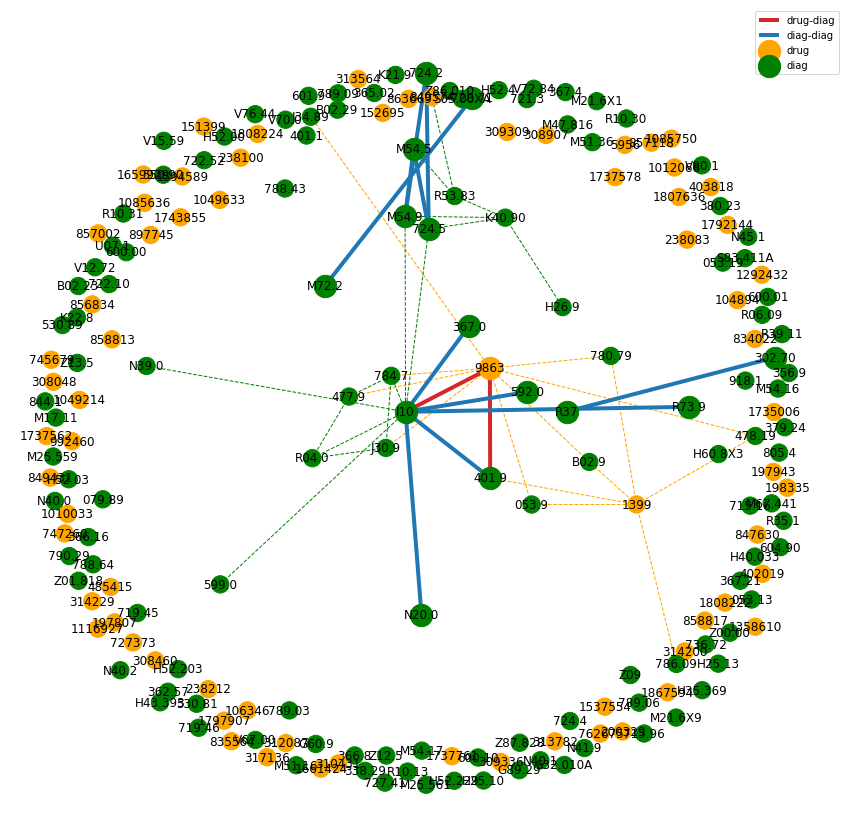

In [77]:
fig, ax = plt.subplots(figsize=(15,15))

PG = nx.Graph()

start = time()
for drug in patient_drugs.rx_cui.unique():
    PG.add_node(drug, color='orange')

for diag in patient_diagnosis.icd_code.unique():
    PG.add_node(diag, color='green')
end = time()
print(end-start, 'Add nodes')

start = time()
# for rxcui in lit_drugs.rx_cui.values:  # drug-diag associations
#     literature_only = medi_associations[medi_associations['rxcui'] == rxcui]
#     for icd_code in literature_only.icd_code.values:
#         if icd_code in PG.nodes:
#             PG.add_edge(rxcui, icd_code, color='orange')

for _, (rxcui, icd) in only_drugs.iterrows():
    if rxcui in PG.nodes and icd in PG.nodes:
        PG.add_edge(rxcui, icd, color='orange')

found_drugs = set()
found_diags = set()
end = time()
print(end-start, 'Add drug_diags')


start = time()
found_associations = set()  # drug-diag associations in real
for rx, icd in PG.edges:
    diag_date = lidi.loc[lidi['icd_code'] == icd, 'new_date']
    drug_date = liti.loc[liti['rx_cui'] == rx, 'new_date']
    for visit in diag_date:
        end_date = visit + timedelta(days=90)  #time span in days between diagnosis and prescrition date
        for prescription in drug_date.unique():
            if visit <= prescription <= end_date:
                found_drugs.add(rx)
                found_diags.add(icd)
                found_associations.add((rx, icd))

for f_rx, f_icd in found_associations:
    PG[f_rx][f_icd]['color'] = 'red'
end = time()
print(end-start, 'check dtug-diags')


start = time()
# for icd_code in lit_diagnosis.icd_code.values:  # diag-diag associations
#     pairs = icd_relations[(icd_relations['disease1'] == icd_code) | (icd_relations['disease2'] == icd_code)]
for _, (disease1, disease2) in only_diags.iterrows():
    if disease1 != disease2 and disease1 in PG.nodes and disease2 in PG.nodes:
        PG.add_edge(disease1, disease2, color='green')
end = time()
print(end-start, 'Add diag-diag')



start = time()
found_dd_associations = set()  # diag-diag associations in real
for d1, d2 in PG.edges:
    if PG[d1][d2]['color'] == 'green':
        for icd1, icd2 in [(d1, d2), (d2, d1)]:
            diag1_date = lidi.loc[lidi['icd_code'] == icd1, 'new_date']
            diag2_date = lidi.loc[lidi['icd_code'] == icd2, 'new_date']
            for diag1_visit in diag1_date:
                end_date = diag1_visit + timedelta(days=90)  #time span in days between two diagnosis
                for diag2_visit in diag2_date:
                    if diag1_visit <= diag2_visit <= end_date:
                        found_diags.update([icd1, icd2])
                        assos = tuple(sorted((icd1, icd2)))
                        found_dd_associations.add(assos)

for f_icd1, f_icd2 in found_dd_associations:
    PG[f_icd1][f_icd2]['color'] = 'blue'
end = time()
print(end-start, 'check diag-diag')


start = time()
attr = list(nx.get_node_attributes(PG, 'color').values())
attr2 = list(nx.get_edge_attributes(PG, 'color').values()) #edge_color

pos= nx.spring_layout(PG, k=0.5)

nx.draw(PG, pos=pos,  with_labels=True, node_color=attr, edge_color=attr2, style='dashed')
nx.draw_networkx_edges(PG, pos=pos, edgelist=list(found_associations), width=4, alpha=1, edge_color="tab:red", label='drug-diag')
nx.draw_networkx_edges(PG, pos=pos, edgelist=list(found_dd_associations), width=4, alpha=1, edge_color="tab:blue", label='diag-diag')
nx.draw_networkx_nodes(PG, pos=pos, nodelist=list(found_drugs), node_size=500, node_color='orange', label='drug')
nx.draw_networkx_nodes(PG, pos=pos, nodelist=list(found_diags), node_size=500, node_color='green', label='diag')

end = time()
print(end-start, 'higlighting')


plt.legend()
plt.show()

In [15]:
patient_id,   '513085458'

(513085458, '513085458')

In [16]:
def filter_nodes(node):
    return True if PG.degree[node] != 0 else False

def filter_edges(e1, e2):
    # e1, e2 = edge
    color = PG[e1][e2]['color']
    allowed_colors = ['red', 'blue', 'green', 'orange']
    return True if color in allowed_colors else False

In [17]:
def get_labels(node):
    label = get_data(f""" SELECT drug_name FROM ka_medi_drugs WHERE rxcui='{node}'""").drug_name.values
    if len(label) != 0:
        return label[0] 
    else:
        label = get_data(f""" SELECT diagnosis_name FROM ka_medi_diagnosis WHERE icd_code='{node}'""").diagnosis_name.values
        if len(label) != 0:
            return label[0]
        else:
            dnet_id = get_data(f""" SELECT disease_id FROM ka_disgenet_mappings WHERE icd_code='{node}'""").disease_id.values
            if len(dnet_id) != 0:
                label = get_data(f""" SELECT disease_name FROM ka_disgenet_labels WHERE disease_id='{dnet_id[0]}'""").disease_name.values
                return label[0] if len(label) != 0 else None
        

In [18]:
sub_PG = nx.subgraph_view(PG, filter_node=filter_nodes, filter_edge=filter_edges)
#sub_PG.edges


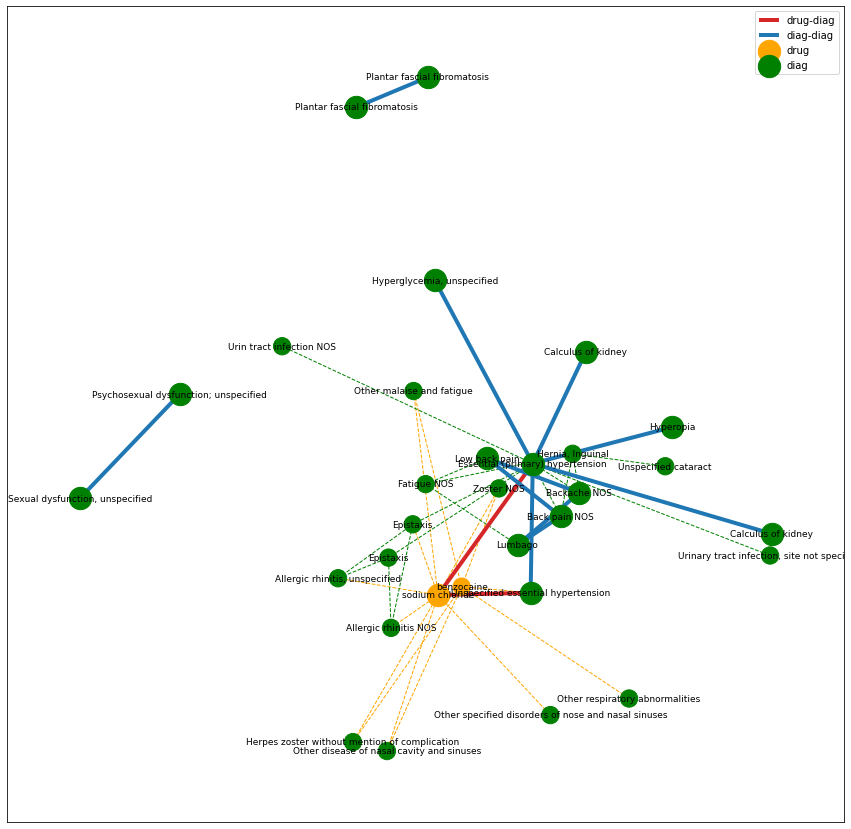

In [19]:
#pos_sub = nx.spring_layout(sub_PG, k=0.9)
pos_sub = pos
#plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15,15))

edge_color_list_c = [nc for _, _, nc in sub_PG.edges(data="color")]
nx.draw_networkx_edges(sub_PG, pos_sub, edge_color=edge_color_list_c, style='dashed')

node_color_list_c = [nc for _, nc in sub_PG.nodes(data="color")]
nx.draw_networkx_nodes(sub_PG, pos_sub, node_color=node_color_list_c)

node_labels = {node: get_labels(node) for node in sub_PG.nodes}
nx.draw_networkx_labels(sub_PG, pos_sub, labels=node_labels, font_size=9)

nx.draw_networkx_edges(sub_PG, pos=pos_sub, edgelist=list(found_associations), width=4, alpha=1, edge_color="tab:red", label='drug-diag')
nx.draw_networkx_edges(sub_PG, pos=pos_sub, edgelist=list(found_dd_associations), width=4, alpha=1, edge_color="tab:blue", label='diag-diag')
nx.draw_networkx_nodes(sub_PG, pos=pos_sub, nodelist=list(found_drugs), node_size=500, node_color='orange', label='drug')
nx.draw_networkx_nodes(sub_PG, pos=pos_sub, nodelist=list(found_diags), node_size=500, node_color='green', label='diag')

plt.legend()
plt.show()

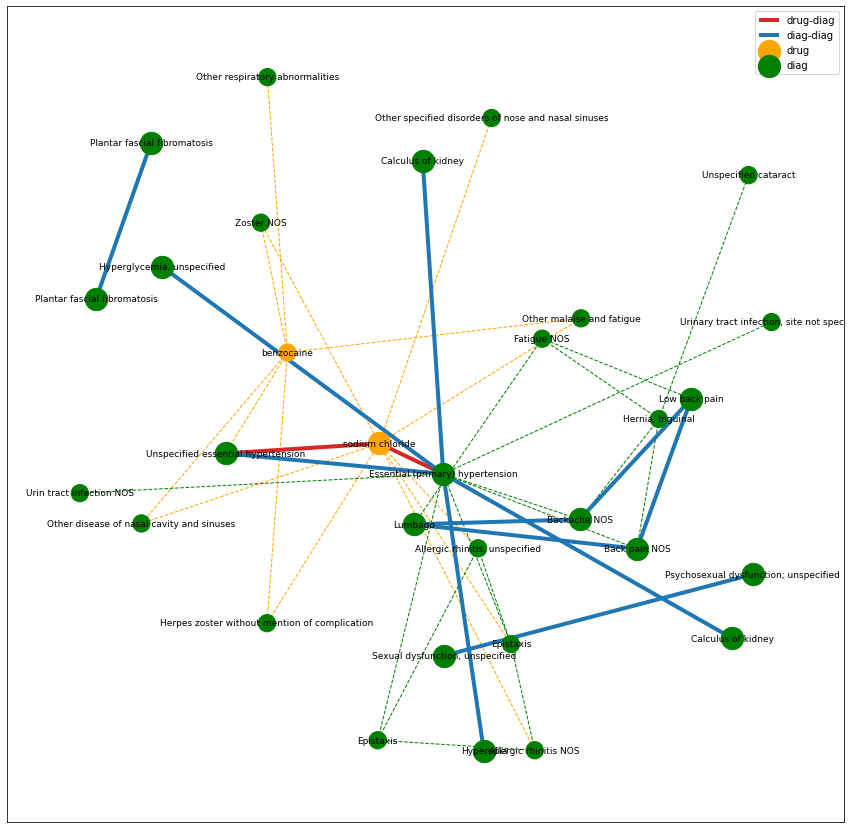

In [20]:
pos_sub = nx.spring_layout(sub_PG, k=0.9)
#plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15,15))

edge_color_list_c = [nc for _, _, nc in sub_PG.edges(data="color")]
nx.draw_networkx_edges(sub_PG, pos_sub, edge_color=edge_color_list_c, style='dashed')

node_color_list_c = [nc for _, nc in sub_PG.nodes(data="color")]
nx.draw_networkx_nodes(sub_PG, pos_sub, node_color=node_color_list_c)

node_labels = {node: get_labels(node) for node in sub_PG.nodes}
nx.draw_networkx_labels(sub_PG, pos_sub, labels=node_labels, font_size=9)

nx.draw_networkx_edges(sub_PG, pos=pos_sub, edgelist=list(found_associations), width=4, alpha=1, edge_color="tab:red", label='drug-diag')
nx.draw_networkx_edges(sub_PG, pos=pos_sub, edgelist=list(found_dd_associations), width=4, alpha=1, edge_color="tab:blue", label='diag-diag')
nx.draw_networkx_nodes(sub_PG, pos=pos_sub, nodelist=list(found_drugs), node_size=500, node_color='orange', label='drug')
nx.draw_networkx_nodes(sub_PG, pos=pos_sub, nodelist=list(found_diags), node_size=500, node_color='green', label='diag')

plt.legend()
plt.show()

In [21]:
sub_edge = [edge for edge in sub_PG.edges if sub_PG[edge[0]][edge[1]]['color'] in ['red', 'blue']]
edge_PG = nx.edge_subgraph(PG, edges=sub_edge)
edge_PG.edges

EdgeView([('I10', '9863'), ('I10', 'N20.0'), ('I10', '592.0'), ('I10', 'R73.9'), ('I10', '367.0'), ('I10', '401.9'), ('M72.2', '728.71'), ('M54.5', '724.5'), ('M54.5', 'M54.9'), ('724.2', '724.5'), ('724.2', 'M54.9'), ('302.70', 'R37'), ('401.9', '9863')])

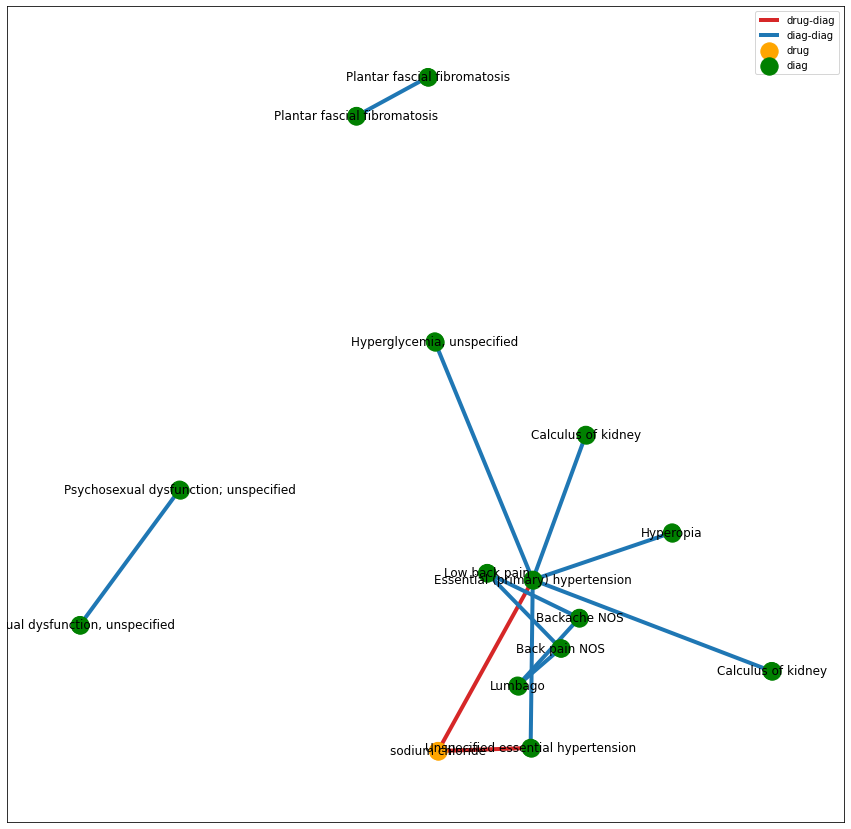

In [22]:
#pos_sub_edge = nx.spring_layout(edge_PG, k=0.9)
pos_sub_edge = pos
#plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15,15))

edge_color_list_c = [nc for _, _, nc in edge_PG.edges(data="color")]
nx.draw_networkx_edges(edge_PG, pos_sub_edge, edge_color=edge_color_list_c)

node_color_list_c = [nc for _, nc in edge_PG.nodes(data="color")]
nx.draw_networkx_nodes(edge_PG, pos_sub_edge, node_color=node_color_list_c)

node_labels = {node: get_labels(node) for node in edge_PG.nodes}
nx.draw_networkx_labels(edge_PG, pos_sub_edge, labels=node_labels, font_size=12)

nx.draw_networkx_edges(edge_PG, pos=pos_sub_edge, edgelist=list(found_associations), width=4, alpha=1, edge_color="tab:red", label='drug-diag')
nx.draw_networkx_edges(edge_PG, pos=pos_sub_edge, edgelist=list(found_dd_associations), width=4, alpha=1, edge_color="tab:blue", label='diag-diag')
nx.draw_networkx_nodes(edge_PG, pos=pos_sub_edge, nodelist=list(found_drugs), node_size=300, node_color='orange', label='drug')
nx.draw_networkx_nodes(edge_PG, pos=pos_sub_edge, nodelist=list(found_diags), node_size=300, node_color='green', label='diag')

plt.legend()

plt.show()

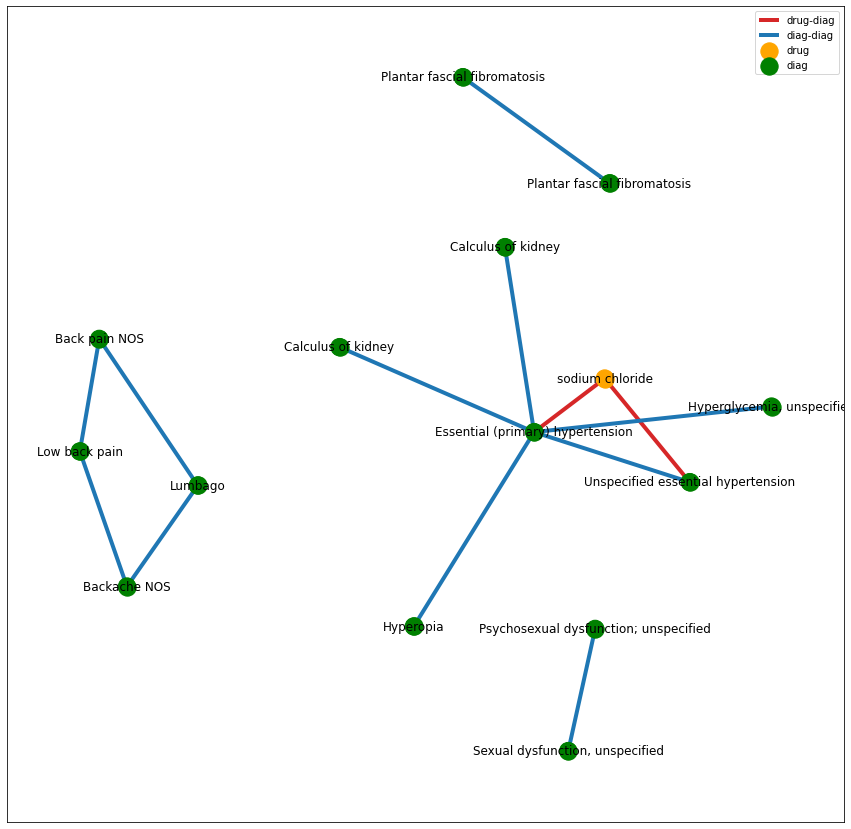

In [23]:
pos_sub_edge = nx.spring_layout(edge_PG, k=0.9)
#pos_sub_edge = pos
#plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15,15))

edge_color_list_c = [nc for _, _, nc in edge_PG.edges(data="color")]
nx.draw_networkx_edges(edge_PG, pos_sub_edge, edge_color=edge_color_list_c)

node_color_list_c = [nc for _, nc in edge_PG.nodes(data="color")]
nx.draw_networkx_nodes(edge_PG, pos_sub_edge, node_color=node_color_list_c)

node_labels = {node: get_labels(node) for node in edge_PG.nodes}
nx.draw_networkx_labels(edge_PG, pos_sub_edge, labels=node_labels, font_size=12)

nx.draw_networkx_edges(edge_PG, pos=pos_sub_edge, edgelist=list(found_associations), width=4, alpha=1, edge_color="tab:red", label='drug-diag')
nx.draw_networkx_edges(edge_PG, pos=pos_sub_edge, edgelist=list(found_dd_associations), width=4, alpha=1, edge_color="tab:blue", label='diag-diag')
nx.draw_networkx_nodes(edge_PG, pos=pos_sub_edge, nodelist=list(found_drugs), node_size=300, node_color='orange', label='drug')
nx.draw_networkx_nodes(edge_PG, pos=pos_sub_edge, nodelist=list(found_diags), node_size=300, node_color='green', label='diag')

plt.legend()

plt.show()

In [24]:
len(PG.edges), len(found_associations), len(found_dd_associations)

(43, 2, 11)

# Method 2 - very slow

for one_visit in patient diagnosis:

subset_drugs = patient drugs prescribed on same visit or following visit

for all_diagnosis in one_visit

for drug in subset_drugs

if association present in medi

change edge color



In [25]:
# all_subs = []
# all_lens = []
# for day_visit in patient_diagnosis['new_date'].unique():
#     diagnosis = patient_diagnosis[patient_diagnosis['new_date'] == day_visit]
#     list_diag = diagnosis.icd_code.unique()
#     end_date = day_visit + timedelta(days=90)

#     drugs_subset = patient_drugs[(patient_drugs['new_date'] >= day_visit) & (patient_drugs['new_date'] <= end_date)]
#     list_drug = drugs_subset.rx_cui.unique()

#     for s_diag in list_diag:
#         for s_drug in list_drug:
#             if ((medi_associations['rxcui'] == s_drug) & (medi_associations['icd_code'] == s_diag)).any():
#                 print('drug-diag : ', s_drug, s_diag)

#     all_subs.append(drugs_subset)
#     all_lens.append((len(drugs_subset), len(drugs_subset.rx_cui.unique())))

# Rough work

In [26]:
# initialize data of lists.
data = {'Name':['Tom', 'nick', 'krish', 'jack'],
        'Age':[20, 21, 19, 18],
        'Place': ['UK', 'US', 'IN', 'DE'],
        'Date': [pd.Timestamp(2017, 2, 25), pd.Timestamp(2018, 3, 29), pd.Timestamp(2018, 6, 29), pd.Timestamp(2019, 1, 25)]}
df= pd.DataFrame(data)
df

,Name,Age,Place,Date
0,Tom,20,UK,2017-02-25
1,nick,21,US,2018-03-29
2,krish,19,IN,2018-06-29
3,jack,18,DE,2019-01-25


In [27]:
((df['Age'] == 21) & (df['Name'] == 'Tom')).any()

False

In [28]:
df['date'] = df['Date'].apply(lambda x: x.date())
df

,Name,Age,Place,Date,date
0,Tom,20,UK,2017-02-25,2017-02-25
1,nick,21,US,2018-03-29,2018-03-29
2,krish,19,IN,2018-06-29,2018-06-29
3,jack,18,DE,2019-01-25,2019-01-25


In [29]:
# for i, j in df.iterrows():
#     for k in df.date:
#         print(i, j.date, k)
#         diff = k - j.date
#         print('diff ', diff)
#         if 0 <= diff.days <= 120:
#             print('less than three months')


In [30]:
fg = df.date[2] - df.date[1]
fg

datetime.timedelta(days=92)

In [31]:
fg.days

92

In [32]:
df.date[2], (df.date[2] + timedelta(days=90))

(datetime.date(2018, 6, 29), datetime.date(2018, 9, 27))

In [33]:
(df.date[2] + timedelta(days=90)) - df.date[2]

datetime.timedelta(days=90)

In [34]:
df.loc[(df['Age'] <= 20) , 'Name']

0      Tom
2    krish
3     jack
Name: Name, dtype: object

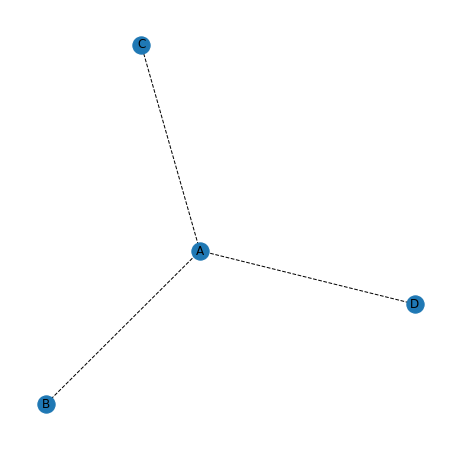

In [35]:
fig, ax = plt.subplots(figsize=(8,8))

relationships = pd.DataFrame({'from': ['A', 'A', 'A'], 
                              'to':   ['B', 'C', 'D']})

G_test = nx.from_pandas_edgelist(relationships, 'from', 'to', create_using=nx.Graph())

nx.draw(G_test, with_labels=True, style='dashed')

In [36]:
get_data(""" SELECT disease_id FROM ka_disgenet_mappings WHERE icd_code='I10'""").disease_id.values

array(['C0020538', 'C0085580', 'C0085580'], dtype=object)

In [37]:
get_data(""" SELECT disease_name FROM ka_disgenet_labels WHERE disease_id='C0020538'""").disease_name.values

array(['Hypertensive disease'], dtype=object)

In [38]:
get_data(f""" SELECT diagnosis_name FROM ka_medi_diagnosis WHERE icd_code='I10'""")

,diagnosis_name
0,Essential (primary) hypertension


In [39]:
get_labels('I10')

'Essential (primary) hypertension'

# Disease-disease associations

In [1]:
1-1

0

In [13]:
# disgenet = pd.read_csv('/home/kamin/data_tables/disgenet_associations.csv', sep=',',names=['diseaseID1', 'diseaseID2', 'associations'])
# disgenet.associations = disgenet.associations.apply(literal_eval)
# disgenet

,diseaseID1,diseaseID2,associations
0,C0000737,C0002871,"[(789.0, D64.9), (789.0, 285.9), (789.00, D64...."
1,C0000737,C0002878,"[(789.0, D55-D59.9), (789.0, D55-D59), (789.00..."
2,C0000737,C0002879,"[(789.0, D59), (789.0, 283.9), (789.0, 283), (..."
3,C0000737,C0002994,"[(789.0, T78.3), (789.00, T78.3), (R10.9, T78.3)]"
4,C0000737,C0003123,"[(789.0, R63.0), (789.0, 783.0), (789.00, R63...."
...,...,...,...
59503,C4721453,C1297882,"[(G64, Q92.2), (350-359.99, Q92.2)]"
59504,C4721453,C1395852,"[(G64, Q69.1), (350-359.99, Q69.1)]"
59505,C4721453,C2239176,"[(G64, C22.0), (350-359.99, C22.0)]"
59506,C4721453,C3542501,"[(G64, 357.0), (350-359.99, 357.0)]"


In [14]:
# disgenet['associations'][1]

[('789.0', 'D55-D59.9'),
 ('789.0', 'D55-D59'),
 ('789.00', 'D55-D59.9'),
 ('789.00', 'D55-D59'),
 ('R10.9', 'D55-D59.9'),
 ('R10.9', 'D55-D59')]

In [24]:
# unique_icd_associations = set()
# for associations_list in disgenet['associations']:
#     for associations in associations_list:
#         pair = ''.join(associations)
#         if '-' not in pair:
#             unique_icd_associations.add(tuple(sorted(associations)))

In [25]:
# len(unique_icd_associations)

106663

In [31]:
# icd_associations = pd.DataFrame(unique_icd_associations, columns=['disease1', 'disease2'])
# icd_associations

,disease1,disease2
0,704.1,K59.09
1,C50,N12
2,Q36,Q70.10
3,494,R07.4
4,712.3,E24.9
...,...,...
106658,M04.8,M60.9
106659,I34.0,M21.20
106660,188.9,781.6
106661,564.00,M21.2


# save file

In [32]:
#icd_associations.to_csv('/home/kamin/data_tables/icd_associations.csv', sep=',', index=False, header=False)

In [34]:
# icd_edges = get_data("SELECT * FROM ka_icd_associations;")
# icd_edges

,disease1,disease2
0,704.1,K59.09
1,C50,N12
2,Q36,Q70.10
3,494,R07.4
4,712.3,E24.9
...,...,...
106658,M04.8,M60.9
106659,I34.0,M21.20
106660,188.9,781.6
106661,564.00,M21.2
